In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

from tqdm.notebook import tqdm
import glob
import numpy as np
from utils_analysis import *
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from scipy.io import loadmat 

import seaborn as sns
import cv2
from skimage import data

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
training_methods = ["dino", "supervised"] 
depth_list = [8, 12]
num_models = 6
num_heads = 6

patch_size = 16
batch_size = 32

transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
video_names = ["MISSP_9a", "Cloud_13a", "MARCH_6b"]#["ADVEN_12a", "Cloud_13a", "DEEPB_11a"]#_c" #  160 # DEEPB_9a_c/0020.png
frame_indices = [50, 260, 511]#[160, 261, 40]

In [5]:
d_label = np.array([[7,8],[9,10]]) - 1

In [6]:
imgs = []
for video_name, frame_idx in zip(video_names, frame_indices):
    img_path = f"../dataset/Costela_Woods_2019/preprocessed_data/clips_png/{video_name}_c/{frame_idx:04d}.png"
    imgs.append(Image.open(img_path))

images = [transform(img).unsqueeze(0) for img in imgs]
num_imgs = len(images)

In [7]:
res_dict = {}
tm = training_methods[0]
for i, depth in enumerate(depth_list):
    print(depth)
    attn_depth = [[] for _ in range(num_imgs)]
    for trial_idx in tqdm(range(num_models)):
        model, device = model_load(tm, trial_idx+1, depth, patch_size)
        #num_heads = model.num_heads
        for img_idx in range(num_imgs):
            with torch.inference_mode():
                attentions_list = model.get_fulllayers_selfattention(images[img_idx].to(device))
        
            attn_layer = []
            for j in range(2): 
                attentions = attentions_list[d_label[i,j]]
                attentions = attentions[:, :, 0, 1:].reshape(num_heads, -1)
                attentions = attentions.detach().cpu().numpy()
                attn_layer.append(attentions[None, :, :])
            attn_layer = np.vstack(attn_layer)
            attn_depth[img_idx].append(attn_layer[None, :, :, :])
    attn_depth_stack = [np.vstack(attn_depth[img_idx]).transpose(1, 0, 2, 3) for img_idx in range(num_imgs)]
    res_dict[str(depth)] = attn_depth_stack

8


  0%|          | 0/6 [00:00<?, ?it/s]

12


  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
len(res_dict[str(depth)])

3

In [9]:
res_dict[str(depth)][0].shape

(2, 6, 6, 817)

In [10]:
labels = np.load("../results/attn_best_label_N2010.npy")

In [11]:
attn_concat = [np.vstack([res_dict[str(depth)][img_idx].reshape(72, -1) for depth in depth_list]) for img_idx in range(num_imgs)]
attn_concat_flat = [attn_concat[img_idx].reshape(144, -1) for img_idx in range(num_imgs)]

In [12]:
attn_concat_flat[0].shape

(144, 817)

In [13]:
attns = [[] for _ in range(num_imgs)]
for img_idx in range(num_imgs):
    w, h = imgs[img_idx].size
    hh, ww = np.array([h/16, w/16]).astype(int)
    for i in range(1, 4):
        idx = np.where(labels == i)[0]
        attn = np.mean(attn_concat_flat[img_idx][idx].reshape(-1, hh, ww), axis=0)
        attns[img_idx].append(attn)

In [14]:
depth = 8
attn_layers = []
for img_idx in range(num_imgs):
    w, h = imgs[img_idx].size
    hh, ww = np.array([h/16, w/16]).astype(int)
    attn_layers.append(res_dict[str(depth)][img_idx][-1, 1].reshape(-1, hh, ww))
    #attn_layers.append(res_dict[str(depth)][img_idx][-1, 1].reshape(-1, hh, ww))

'\ndepth = 8\nattn_layers = []\nfor img_idx in range(num_imgs):\n    w, h = imgs[img_idx].size\n    hh, ww = np.array([h/16, w/16]).astype(int)\n    attn_layers.append(res_dict[str(depth)][img_idx][-1, 1].reshape(-1, hh, ww))\n    #attn_layers.append(res_dict[str(depth)][img_idx][-1, 1].reshape(-1, hh, ww))\n'

In [15]:
dataset_dir = "../dataset/Costela_Woods_2019/preprocessed_data/clips_png"
movie_info = np.load(f"{dataset_dir}/movie_info.npz", allow_pickle=True)

In [16]:
img_original = []
aspects = []
for i in range(num_imgs):
    video_name = video_names[i]
    frame_idx = frame_indices[i]
    """
    if i == 0:
        img = cv2.imread(f"../figures/masked_frames/{video_name}_c_{frame_idx:04d}.png")
    else:
        img = cv2.imread(f"../dataset/Costela_Woods_2019/preprocessed_data/clips_png_original/{video_name}_c/{frame_idx:04d}.png")
    """
    img = cv2.imread(f"../dataset/Costela_Woods_2019/preprocessed_data/clips_png_original/{video_name}_c/{frame_idx:04d}.png")
    img_original.append(img[:, :, ::-1])

    m_info = movie_info[video_name + "_c"].item()
    size = m_info["size"]
    resize = m_info["resize"]
    size_ratio = size / resize
    aspects.append(size_ratio[1] / size_ratio[0])

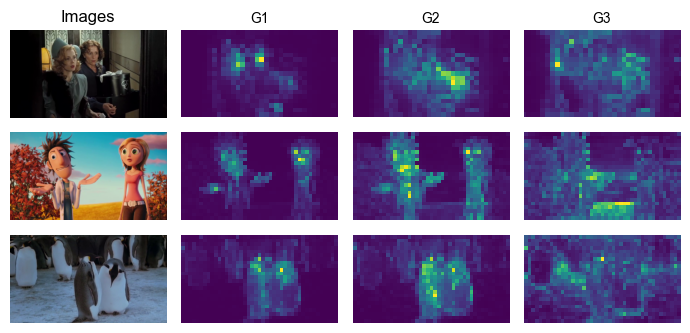

In [17]:
fig, axes = plt.subplots(num_imgs, 4, figsize=(7, 3.5))#, tight_layout=True)
for i in range(num_imgs):
    axes[i, 0].imshow(img_original[i])
    #axes[i, 0].set_ylabel(str(i))
    for jj, j in enumerate([0, 2, 1]):
        axes[i, 1+jj].imshow(attns[i][j], aspect=aspects[i])
for i in range(num_imgs):
    for j in range(4):
        axes[i, j].axis("off")
axes[0, 0].set_title("Images")
for j in range(3):
    axes[0, 1+j].set_title(f"G{j+1}", fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
axes[0, 0].set_xlim(100, 743)
for j in range(1, 4):
    axes[0, j].set_xlim(5.04, 37.96)
#fig.suptitle(f"DINO ViT-{depth}, layer #{d_idx+1}, model #{m_idx+1}")
plt.tight_layout()
fig.savefig(f"../figures/example_attention_maps_CW2019_group_head.svg", dpi=300)

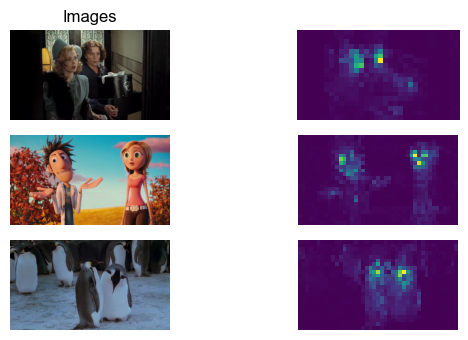

In [18]:
fig, axes = plt.subplots(num_imgs, 2, figsize=(7, 3.5))#, tight_layout=True)
for i in range(num_imgs):
    axes[i, 0].imshow(img_original[i])
    #axes[i, 0].set_ylabel(str(i))
    axes[i, 1].imshow(attn_layers[i][0], aspect=aspects[i])
for i in range(num_imgs):
    for j in range(2):
        axes[i, j].axis("off")
axes[0, 0].set_title("Images")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
axes[0, 0].set_xlim(100, 743)
axes[0, 1].set_xlim(5.04, 37.96)
#fig.suptitle(f"DINO ViT-{depth}, layer #{d_idx+1}, model #{m_idx+1}")
plt.tight_layout()
fig.savefig(f"../figures/example_attention_maps_CW2019_single_head.svg", dpi=300)

In [19]:
"""
dataset_dir = "../dataset/Costela_Woods_2019/preprocessed_data/clips_png"
movie_info = np.load(f"{dataset_dir}/movie_info.npz", allow_pickle=True)

movie_name = video_names[0] + "_c"
print(movie_name)
m_info = movie_info[movie_name].item()
size = m_info["size"]
resize = m_info["resize"]
size_ratio = size / resize
num_frame = m_info["num_frames"]

image_path_list = sorted(glob.glob(f"{dataset_dir}/{movie_name}/*.png"))
"""

'\ndataset_dir = "../dataset/Costela_Woods_2019/preprocessed_data/clips_png"\nmovie_info = np.load(f"{dataset_dir}/movie_info.npz", allow_pickle=True)\n\nmovie_name = video_names[0] + "_c"\nprint(movie_name)\nm_info = movie_info[movie_name].item()\nsize = m_info["size"]\nresize = m_info["resize"]\nsize_ratio = size / resize\nnum_frame = m_info["num_frames"]\n\nimage_path_list = sorted(glob.glob(f"{dataset_dir}/{movie_name}/*.png"))\n'

In [20]:
"""
frame_idx = 50
img2 = cv2.imread(f"../figures/masked_frames/{movie_name}_{frame_idx:04d}.png")

plt.subplot(1,2,1)
plt.imshow(img2[:, :, ::-1])
plt.subplot(1,2,2)
plt.imshow(attentions[5].detach().cpu().numpy(), aspect=size_ratio[1] / size_ratio[0])
"""

'\nframe_idx = 50\nimg2 = cv2.imread(f"../figures/masked_frames/{movie_name}_{frame_idx:04d}.png")\n\nplt.subplot(1,2,1)\nplt.imshow(img2[:, :, ::-1])\nplt.subplot(1,2,2)\nplt.imshow(attentions[5].detach().cpu().numpy(), aspect=size_ratio[1] / size_ratio[0])\n'